In [1]:
import os
os.chdir("..")

In [24]:
from data.data_classes import *
from data.datamodules import *
import matplotlib.pyplot as plt
import numpy as np
from data.data_classes import *
from enums import Partition
from models.GAT_Modelv5_Regression import GAT_Modelv5_Regression
from torch_geometric.data import Batch

In [25]:
# Load datamodule
data_module = Graph_DataModule_CSV(
    dataset=MyHELEN(),
    num_segments=512,
    batch_size=1,
    mode=Partition.CuPID,
    features={"x_center":True, "y_center":True, "colour":True, "width":True, "height":True, "stdev":True}
)

# Load model
model_ckpt = r"saved\HELEN_CP_512_DataModule\XYCWHS\GAT_Modelv5_Regression\Run_ID__2024-09-27__17-41-02\checkpoints\bestLoss.pt"
model = GAT_Modelv5_Regression(data_module.num_features, data_module.num_classes)
model.load_state_dict(torch.load(model_ckpt, weights_only=True))
model = model.eval()

In [22]:
def plot(data_module, start_idx, number_to_view):
    # Plotting
    _, axes = plt.subplots(number_to_view, 3, figsize=(15, number_to_view*5))
    fontsize = 8

    for i in range(number_to_view):
        idx = start_idx + i

        # Get axes
        ax1 = axes[i][0]
        ax2 = axes[i][1]
        ax3 = axes[i][2]

        # Retrieve information
        original_image, gt_landmarks = data_module.test_set[idx]
        partitioned_image = data_module.partition_test_set[idx][0]
        graph_data_object = data_module.graph_test_set[idx]
        batch = Batch.from_data_list([graph_data_object])
        pr_landmarks = model(batch.x.float(), batch.edge_index, batch.batch)

        gt_landmarks = np.array(gt_landmarks).reshape((-1, 2))*224
        pr_landmarks = pr_landmarks.detach().numpy().reshape((-1, 2))*224

        ax1.imshow(original_image)
        for coord in gt_landmarks:
            ax1.scatter(*coord, c="red", s=1)
        ax1.set_title(f"Original Image {idx} w/ Ground Truth Landmarks", fontsize=fontsize)
        ax1.set_xticks([])
        ax1.set_yticks([])

        ax2.imshow(partitioned_image)
        for coord in gt_landmarks:
            ax2.scatter(*coord, c="red", s=1)
        ax2.set_title(f"Partitioned Image {idx} w/ Ground Truth Landmarks", fontsize=fontsize)
        ax2.set_xticks([])
        ax2.set_yticks([])

        ax3.imshow(original_image)
        for coord in pr_landmarks:
            ax3.scatter(*coord, c="red", s=1)
        ax3.set_title(f"Original Image {idx} w/ Predicted Landmarks", fontsize=fontsize)
        ax3.set_xticks([])
        ax3.set_yticks([])

    plt.show()

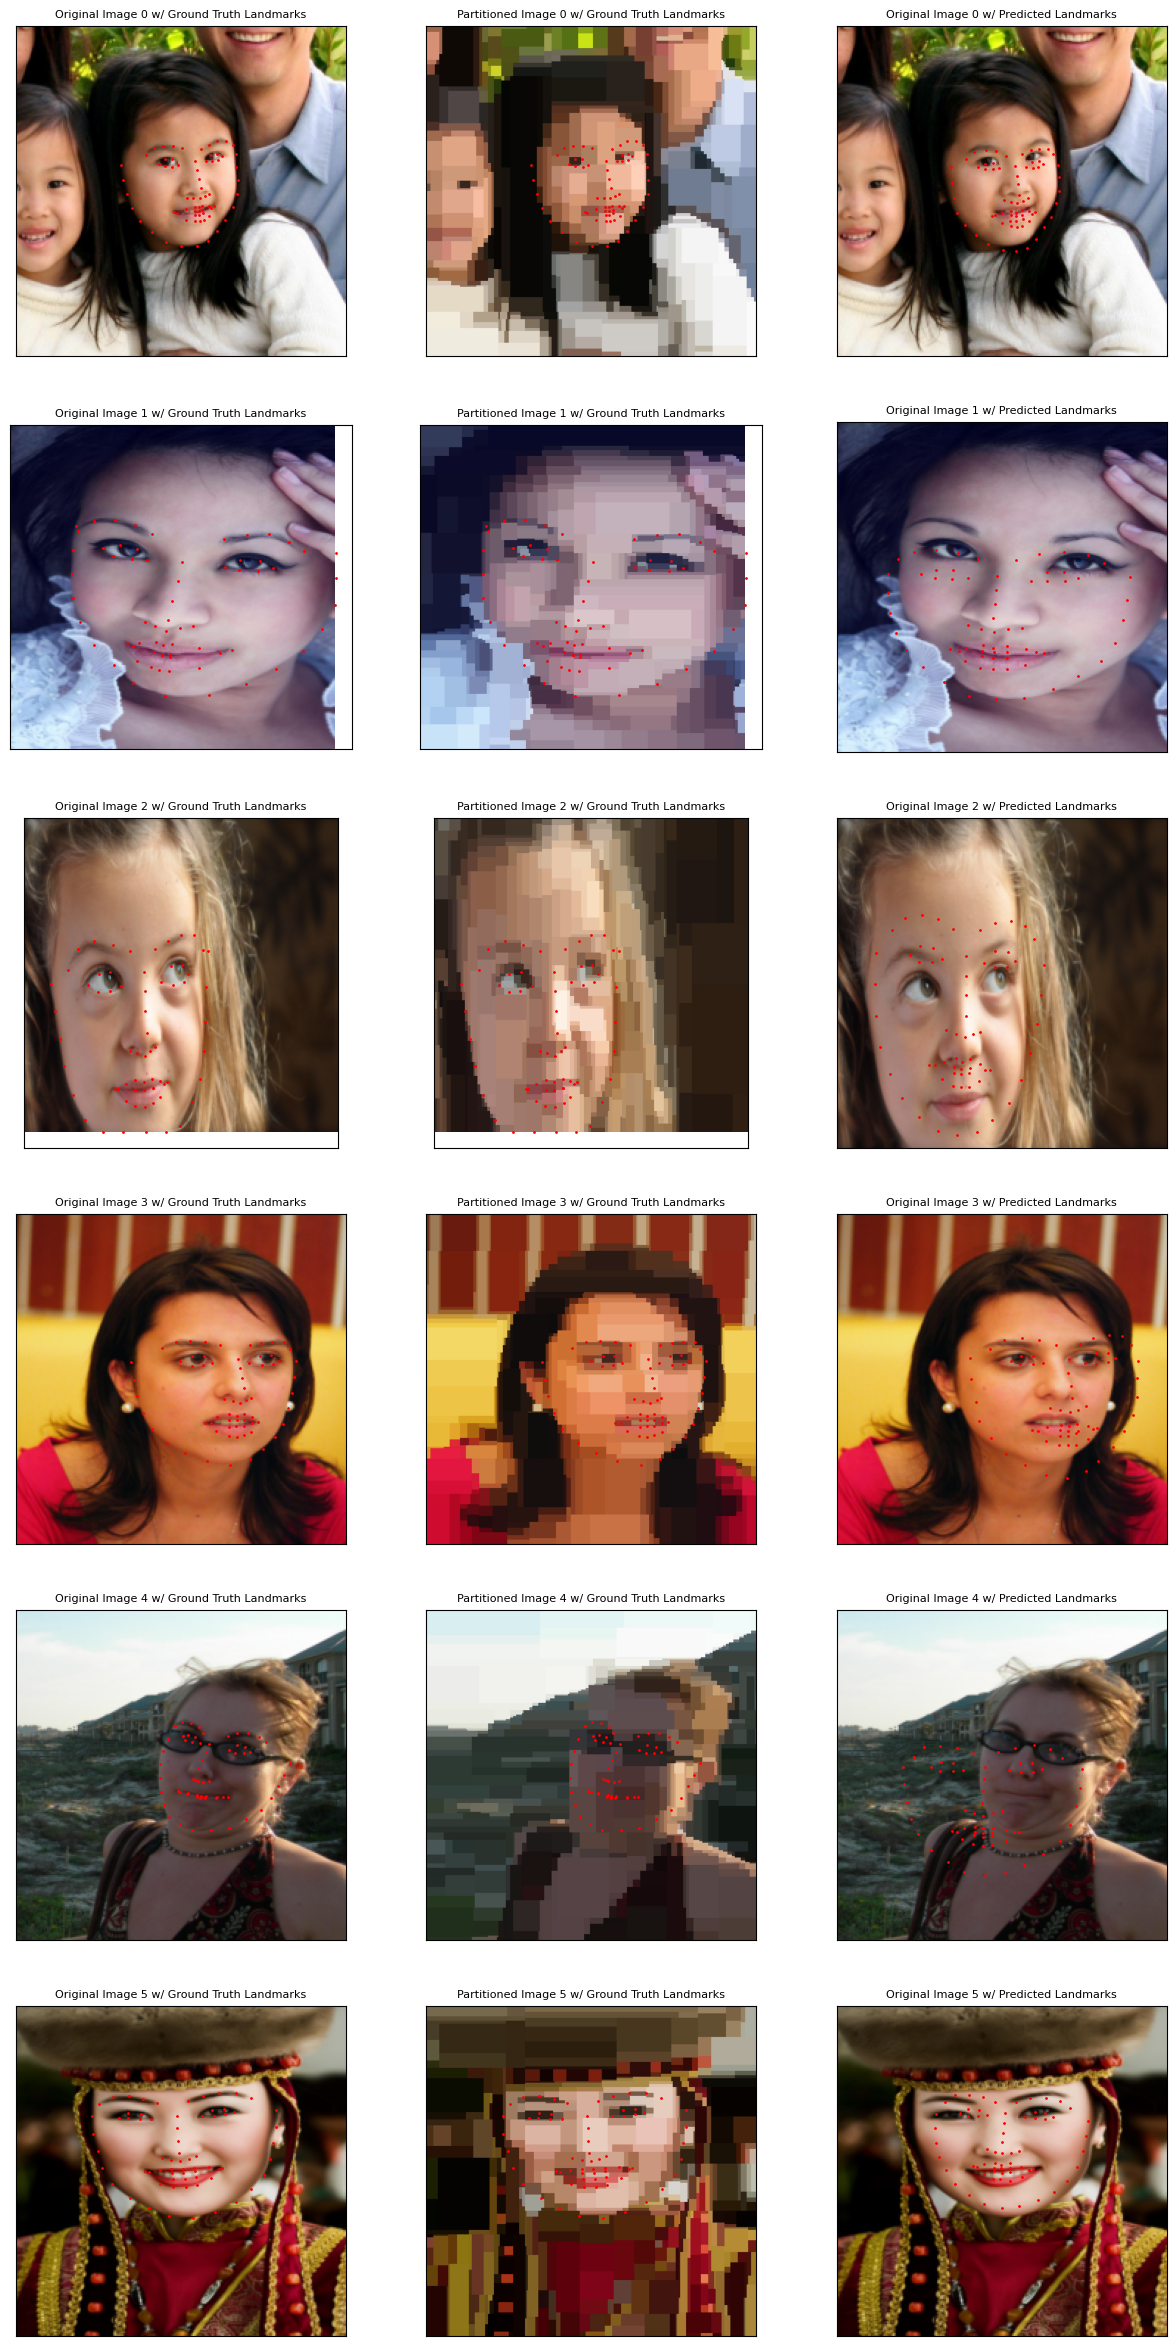

In [30]:
start_idx = 0
number_of_images = 6
plot(data_module, start_idx, number_of_images)